In [ ]:
!pip install tensorflow

## STEP 1. Project setting

In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio
from IPython import display  # For displaying images in Colab/Jupyter

In [6]:
def load_data(label=None):
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
    if label:
        df = pd.DataFrame(list(zip(train_x, train_y)), columns=['image', 'label'])
        df = df[df['label']==label]
        train_x = np.array([i for i in list(df['image'])])
        df = pd.DataFrame(list(zip(test_x, test_y)), columns =['image', 'label'])
        df = df[df['label']==label]
        test_x = np.array([i for i in list(df['image'])])
    return train_x, test_x

In [7]:
train_x, test_x = load_data()

train_x.shape

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


(50000, 32, 32, 3)

## STEP 2. Generator Model

In [10]:
def build_generator(latent_dim=100):
    """
    Builds a generator model for 32x32x3 images.

    Args:
        latent_dim: Dimension of the input noise vector (default: 100).

    Returns:
        A Keras Model representing the generator.
    """
    model = tf.keras.Sequential()

    # Project and reshape the noise vector
    model.add(tf.keras.layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(latent_dim,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((8, 8, 256)))  # Output: 8x8x256

    # Upsample to 16x16
    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())  # Output: 16x16x128

    # Upsample to 32x32
    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())  # Output: 32x32x64

    # Output layer
    model.add(tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    # Output: 32x32x3.  tanh activation for [-1, 1] range.

    return model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Generated image shape: (1, 32, 32, 3)


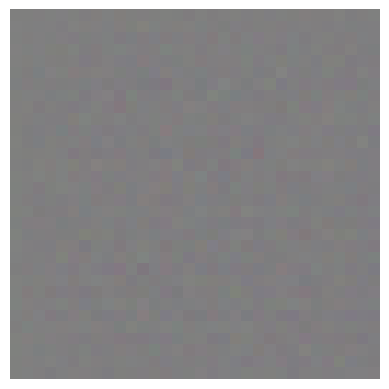

In [11]:
# Test the generator
generator = build_generator()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)  # Generate an image
print("Generated image shape:", generated_image.shape)  # Check output shape
plt.imshow((generated_image[0, :, :, :] + 1) / 2) # Display, scaling to [0, 1]
plt.axis('off')
plt.show()

## STEP 3. Discriminator Model

In [12]:
def build_discriminator():
    """
    Builds a discriminator model for 32x32x3 images.

    Returns:
        A Keras Model representing the discriminator.
    """
    model = tf.keras.Sequential()

    # Downsample from 32x32 to 16x16
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))  # Dropout for regularization

    # Downsample to 8x8
    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    # Flatten and output
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # Sigmoid for probability output

    return model

In [13]:
# Test the discriminator
discriminator = build_discriminator()
decision = discriminator(generated_image)
print("Discriminator output:", decision)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Discriminator output: tf.Tensor([[0.49878347]], shape=(1, 1), dtype=float32)


## STEP 4. Loss Functions and Optimizers

In [18]:
# Binary cross-entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False) # Use from_logits=False with sigmoid activation

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.round(real_output) == 1, tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.round(fake_output) == 0, tf.float32))
    return real_accuracy, fake_accuracy

In [19]:
# Optimizers (using different learning rates)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## STEP 5. Training Loop - Detailed Implementation


In [20]:
@tf.function  # For faster execution (graph compilation)
def train_step(images, batch_size, latent_dim):
    noise = tf.random.normal([batch_size, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        real_acc, fake_acc = discriminator_accuracy(real_output, fake_output)


    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_acc, fake_acc

In [21]:
def generate_and_save_images(model, epoch, test_input, save_dir):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :] + 1) / 2)  # Rescale to [0, 1] for display
        plt.axis('off')

    plt.savefig(os.path.join(save_dir, 'image_at_epoch_{:04d}.png'.format(epoch)))
    plt.close(fig)  # Close the figure to free memory
    plt.show() # Remove or comment out plt.show() to prevent immediate display

In [22]:
def draw_train_history(history, save_dir):
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    # Plot losses
    axes[0].plot(history['gen_loss'], label='Generator Loss')
    axes[0].plot(history['disc_loss'], label='Discriminator Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Plot accuracies
    axes[1].plot(history['real_acc'], label='Real Accuracy')
    axes[1].plot(history['fake_acc'], label='Fake Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True)
    plt.savefig(os.path.join(save_dir, 'training_history.png'))
    plt.close(fig)
    # plt.show() # Remove or comment out plt.show()

In [23]:
# Checkpoint setup
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [24]:
def train(dataset, epochs, batch_size, latent_dim, save_dir):

    # Create a directory to save generated images
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Fixed seed for generating consistent images during training
    seed = tf.random.normal([16, latent_dim])

    history = {'gen_loss': [], 'disc_loss': [], 'real_acc': [], 'fake_acc': []}

    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        for image_batch in dataset:
            gen_loss, disc_loss, real_acc, fake_acc = train_step(image_batch, batch_size, latent_dim)

            # Append to history
            history['gen_loss'].append(gen_loss.numpy())
            history['disc_loss'].append(disc_loss.numpy())
            history['real_acc'].append(real_acc.numpy())
            history['fake_acc'].append(fake_acc.numpy())

        # Produce images for the GIF as we go
        display.clear_output(wait=True)  # Clear the previous epoch's output
        generate_and_save_images(generator, epoch + 1, seed, save_dir)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print(f'  Loss - Generator: {gen_loss:.4f}, Discriminator: {disc_loss:.4f}')
        print(f'  Accuracy - Real: {real_acc:.4f}, Fake: {fake_acc:.4f}')


    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed, save_dir)
    draw_train_history(history, save_dir) # Draw history graph
    return history


In [25]:
# Create a dummy dataset (replace with your actual data loading)
# Example:  Creating random images for demonstration purposes.  You *MUST*
# replace this with your actual image dataset loading.
def create_dummy_dataset(num_samples, image_shape):
    images = np.random.rand(num_samples, *image_shape).astype(np.float32)
    images = (images - 0.5) / 0.5   # Normalize to [-1, 1] to match generator output
    return images

num_samples = 60000  # Example: 60,000 images
image_shape = (32, 32, 3)
dummy_images = create_dummy_dataset(num_samples, image_shape)

# Convert to TensorFlow Dataset
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(dummy_images).shuffle(num_samples).batch(BATCH_SIZE)

# --- Training Configuration ---
EPOCHS = 50
LATENT_DIM = 100
SAVE_DIR = 'generated_images' # Directory for saving generated images.

In [26]:
# --- Start Training ---
train(train_dataset, EPOCHS, BATCH_SIZE, LATENT_DIM, SAVE_DIR)

# --- Create GIF ---
def create_gif(image_dir, gif_name):
    images = []
    filenames = sorted([f for f in os.listdir(image_dir) if f.startswith('image_at_epoch_')])
    for filename in filenames:
        images.append(imageio.imread(os.path.join(image_dir, filename)))
    imageio.mimsave(gif_name, images, duration=0.5)  # Adjust duration as needed


create_gif(SAVE_DIR, 'training.gif')
print("Training Complete.  GIF created.")

<ipython-input-26-da7a53d47e0b>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(os.path.join(image_dir, filename)))


Training Complete.  GIF created.


<ipython-input-26-da7a53d47e0b>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(os.path.join(image_dir, filename)))


Training Complete.  GIF created.


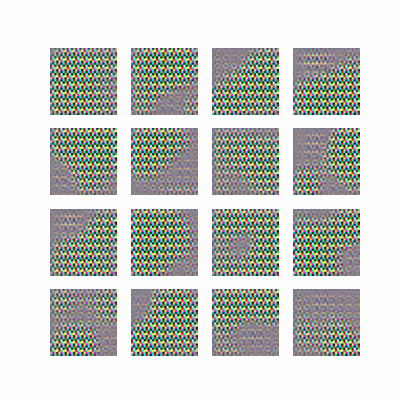

In [36]:
from IPython.display import Image

create_gif(SAVE_DIR, 'training.gif')
print("Training Complete.  GIF created.")
anim_file = '/content/training.gif'
Image(anim_file)

## STEP 6: GAN Training Improvements